<a href="https://colab.research.google.com/github/juancarlosdp03/Matching-networks/blob/main/MatchingNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes Neuronales y Algoritmo de Gale-Shapley

Este notebook implementa una solución híbrida que combina **Machine Learning** (Perceptrón Multicapa) con **Teoría de Juegos** (Algoritmo de Gale-Shapley) para resolver el problema del matrimonio estable en un escenario donde las preferencias no son explícitas.

###Objetivos:
1.  Entrenar redes neuronales con datos reales de *Speed Dating* para inferir la probabilidad de que dos personas quieran una segunda cita.
2.  Convertir estas probabilidades en listas ordenadas de preferencias estrictas.
3.  Ejecutar el algoritmo de Gale-Shapley para encontrar el emparejamiento estable óptimo.
4.  Comprobar matemáticamente la estabilidad de las parejas formadas.

## 1. Carga y Preprocesamiento de Datos
En esta sección cargaremos el dataset *Speed Dating Experiment* directamente desde el repositorio. Realizaremos una limpieza exhaustiva para evitar el *Data Leakage* (fuga de información), eliminando variables que revelen el futuro de la cita y quedándonos solo con los atributos observables *a priori*.

In [16]:
import pandas as pd

url_github = 'https://raw.githubusercontent.com/juancarlosdp03/Matching-networks/refs/heads/main/Speed%20Dating%20Data.csv'

print("Descargando el dataset automáticamente desde GitHub...")

df = pd.read_csv(url_github, encoding='ISO-8859-1')

print(f"¡Dataset cargado con éxito! Tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

Descargando el dataset automáticamente desde GitHub...
¡Dataset cargado con éxito! Tiene 8378 filas y 195 columnas.


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv(url_github, encoding='ISO-8859-1')

# IDs (Imprescindibles para Gale-Shapley, eliminables para la Red Neuronal)
id_cols = ['iid', 'pid', 'gender']

# Variable objetivo
target_col = 'dec'

# Variables pre-cita (Lo que realmente define la compatibilidad a priori)
# Ejemplos: intereses, edad, objetivo de la cita y las valoraciones que se dieron DURANTE la cita
feature_cols = [
    'age', 'age_o', 'imprace', 'imprelig', 'goal', 'date', 'go_out',
    'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
    'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
    'music', 'shopping', 'yoga',
    'attr', 'sinc', 'intel', 'fun', 'amb', 'shar'
]

# Nos quedamos solo con las columnas que queremos y eliminamos filas donde falte la variable objetivo o los IDs
df_clean = df[id_cols + feature_cols + [target_col]].copy()
df_clean = df_clean.dropna(subset=id_cols + [target_col])

# Separamos los metadatos (IDs) de los datos de entrenamiento (X, y)
metadata = df_clean[id_cols]
X_raw = df_clean[feature_cols]
y = df_clean[target_col]

# Tratamiento de Valores Ausentes (Missings), rellenando con la mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Volvemos a convertir a DataFrame para no perder los nombres de las columnas
X = pd.DataFrame(X_scaled, columns=feature_cols)

# División Train/Test
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)

# Recuperamos los IDs del test set para usarlos luego en Gale-Shapley
metadata_test = metadata.iloc[idx_test].reset_index(drop=True)

print(f"Entrenaremos con {X_train.shape[0]} citas y {X_train.shape[1]} variables.")
print(f"El Test Set tiene {X_test.shape[0]} citas.")

Entrenaremos con 6694 citas y 30 variables.
El Test Set tiene 1674 citas.


## 2. Entrenamiento de Redes Neuronales
Dado que hombres y mujeres pueden tener criterios de selección diferentes, entrenaremos **dos modelos independientes**:
* **Modelo M (Hombres):** Aprende a predecir qué mujeres les gustarán a los hombres.
* **Modelo W (Mujeres):** Aprende a predecir qué hombres les gustarán a las mujeres.

Usaremos una arquitectura de red neuronal con capas ocultas (16, 8) y función de activación ReLU.

In [8]:
# Recuperamos la columna 'gender' de nuestros metadatos
gender_train = metadata.iloc[idx_train]['gender'].values
gender_test = metadata.iloc[idx_test]['gender'].values

# Filtramos los datos de entrenamiento
X_train_mujeres = X_train[gender_train == 0]
y_train_mujeres = y_train[gender_train == 0]

X_train_hombres = X_train[gender_train == 1]
y_train_hombres = y_train[gender_train == 1]

# Filtramos los datos de test
X_test_mujeres = X_test[gender_test == 0]
y_test_mujeres = y_test[gender_test == 0]

X_test_hombres = X_test[gender_test == 1]
y_test_hombres = y_test[gender_test == 1]

print(f"El entrenamiento se hace con {len(X_train_mujeres)} citas de mujeres y {len(X_train_hombres)} citas de hombres.\n")

# Creamos los dos modelos
# 2 capas ocultas: la primera con 16 neuronas y la segunda con 8.
modelo_mujeres = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', max_iter=500, random_state=42)
modelo_hombres = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', max_iter=500, random_state=42)

# Entrenamos los modelos
modelo_mujeres.fit(X_train_mujeres, y_train_mujeres)

modelo_hombres.fit(X_train_hombres, y_train_hombres)

# Evaluamos los modelos
pred_mujeres = modelo_mujeres.predict(X_test_mujeres)
acc_mujeres = accuracy_score(y_test_mujeres, pred_mujeres)

pred_hombres = modelo_hombres.predict(X_test_hombres)
acc_hombres = accuracy_score(y_test_hombres, pred_hombres)

print(f"Exactitud:")
print(f"Modelo Mujeres: {acc_mujeres * 100:.2f}%")
print(f"Modelo Hombres: {acc_hombres * 100:.2f}%")

El entrenamiento se hace con 3326 citas de mujeres y 3368 citas de hombres.



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Exactitud:
Modelo Mujeres: 77.51%
Modelo Hombres: 81.25%


## 3. Generación de Listas de Preferencias y Algoritmo de Gale-Shapley
El algoritmo clásico de Gale-Shapley requiere listas de preferencias estrictas (sin empates). Las redes neuronales nos dan una ventaja aquí: al predecir una **probabilidad continua**, podemos ordenar a los candidatos de mayor a menor probabilidad.

A continuación:
1.  Calculamos la probabilidad de *match* para todas las parejas posibles en el conjunto de Test.
2.  Construimos las listas de preferencias ordenadas.
3.  Ejecutamos el algoritmo **Men-Proposing** (los hombres proponen) para encontrar el emparejamiento estable.

In [11]:
# Obtenemos las probabilidades usando predict_proba
# Esto nos devuelve dos columnas: [Probabilidad de NO, Probabilidad de SÍ], elegimos columna 1 (Sí)
probs_mujeres = modelo_mujeres.predict_proba(X_test_mujeres)[:, 1]
probs_hombres = modelo_hombres.predict_proba(X_test_hombres)[:, 1]

# Reconstruimos un DataFrame con los resultados para saber quién es quién
df_test_mujeres = metadata.iloc[idx_test][metadata.iloc[idx_test]['gender'] == 0].copy()
df_test_hombres = metadata.iloc[idx_test][metadata.iloc[idx_test]['gender'] == 1].copy()

# Asignamos las probabilidades predichas
df_test_mujeres['score'] = probs_mujeres
df_test_hombres['score'] = probs_hombres


# Construimos las listas de preferencias
def crear_listas_preferencias(df_hombres, df_mujeres):
    pref_hombres = {}
    pref_mujeres = {}

    for iid, grupo in df_test_hombres.groupby('iid'):
        candidatas_ordenadas = grupo.sort_values('score', ascending=False)['pid'].astype(int).tolist()
        pref_hombres[iid] = candidatas_ordenadas

    for iid, grupo in df_test_mujeres.groupby('iid'):
        candidatos_ordenados = grupo.sort_values('score', ascending=False)['pid'].astype(int).tolist()
        pref_mujeres[iid] = candidatos_ordenados

    return pref_hombres, pref_mujeres

preferencias_hombres, preferencias_mujeres = crear_listas_preferencias(df_test_hombres, df_test_mujeres)

# Vemos un ejemplo
un_hombre_id = list(preferencias_hombres.keys())[0]
print(f"Ejemplo de lista de preferencias para el hombre {un_hombre_id}:")
print(f"Mujeres ordenadas por gusto: {preferencias_hombres[un_hombre_id]}")

# Algoritmo de Gale-Shapley

def gale_shapley(men_prefs, women_prefs):
    matches = {}
    free_men = list(men_prefs.keys()) # Lista de hombres solteros

    # Mientras haya hombres solteros que tengan a quién proponer:
    while free_men:
        man = free_men.pop(0) # Cogemos al primer soltero
        man_list = men_prefs.get(man, []) # Su lista de preferencias

        if not man_list:
            # Si su lista está vacía (no le gusta nadie o todos le rechazaron), se queda soltero
            continue

        # El hombre propone a su primera opción
        woman = man_list.pop(0)

        # Miramos si la mujer ya tiene pareja
        current_husband = matches.get(woman)

        if not current_husband:
            # Si está libre, acepta temporalmente
            matches[woman] = man
        else:
            # Si ya tiene pareja, tiene que elegir
            # Para saber a quién prefiere ella, miramos su lista de preferencias
            w_list = women_prefs.get(woman, [])

            # Verificamos si ambos están en su lista
            if man in w_list and current_husband in w_list:
                if w_list.index(man) < w_list.index(current_husband):
                    matches[woman] = man      # Se queda con el nuevo
                    free_men.append(current_husband)
                else:
                    # Ella prefiere a su actual pareja
                    free_men.append(man)
            elif man in w_list:
                # Si el nuevo está en la lista y el actual no... (caso raro)
                matches[woman] = man
                free_men.append(current_husband)
            else:
                # Si el nuevo no está en su lista, rechazo automático
                free_men.append(man)

    return matches

parejas_estables = gale_shapley(preferencias_hombres, preferencias_mujeres)

print(f"Se han formado {len(parejas_estables)} parejas estables.")
print("Ejemplo de parejas formadas (Mujer - Hombre):")
for i, (mujer, hombre) in enumerate(list(parejas_estables.items())[:5]):
    print(f"Pareja {i+1}: {int(mujer)} - {int(hombre)}")

Ejemplo de lista de preferencias para el hombre 11:
Mujeres ordenadas por gusto: [8, 2, 7]
Se han formado 213 parejas estables.
Ejemplo de parejas formadas (Mujer - Hombre):
Pareja 1: 8 - 11
Pareja 2: 9 - 12
Pareja 3: 2 - 13
Pareja 4: 10 - 17
Pareja 5: 1 - 19


## 4. Validación Matemática y Resultados
La prueba de fuego de este proyecto no es solo que el algoritmo termine, sino que el resultado sea **estable**.

Un emparejamiento es estable si **NO existen pares de bloqueo**.
> **Definición de Par de Bloqueo:** Un hombre $m$ y una mujer $w$ que **no** están juntos, pero que se prefieren mutuamente más que a sus parejas actuales.

El siguiente código recorre todas las combinaciones posibles para certificar que nuestro emparejamiento es estable.

In [12]:
def verificar_estabilidad(matches, scores_hombres, scores_mujeres):
    # Invertimos para tener fácil acceso {hombre: mujer}
    matches_inv = {v: k for k, v in matches.items()}

    pares_bloqueo = []

    # Recorremos todos los hombres y mujeres del test
    hombres_ids = list(scores_hombres.keys())
    mujeres_ids = list(scores_mujeres.keys())

    for m in hombres_ids:
        for w in mujeres_ids:

            # Si ya están juntos, no pueden bloquear
            if matches_inv.get(m) == w:
                continue

            # Parejas actuales
            mujer_actual_de_m = matches_inv.get(m)
            hombre_actual_de_w = matches.get(w)

            # Obtenemos las probabilidades de match
            score_m_w = -1
            if m in scores_hombres and w in scores_hombres[m]:
                 pass

            # Vemos si está w antes en la lista de m que su pareja actual

            lista_m = preferencias_hombres.get(m, [])
            lista_w = preferencias_mujeres.get(w, [])

            if w in lista_m and mujer_actual_de_m in lista_m:
                prefiere_nueva = lista_m.index(w) < lista_m.index(mujer_actual_de_m)
            elif w in lista_m and not mujer_actual_de_m: # Si m estaba soltero
                prefiere_nueva = True
            else:
                prefiere_nueva = False

            if m in lista_w and hombre_actual_de_w in lista_w:
                prefiere_nuevo = lista_w.index(m) < lista_w.index(hombre_actual_de_w)
            elif m in lista_w and not hombre_actual_de_w: # Si w estaba soltera
                prefiere_nuevo = True
            else:
                prefiere_nuevo = False

            # CONDICIÓN DE BLOQUEO: AMBOS PREFIEREN CAMBIAR
            if prefiere_nueva and prefiere_nuevo:
                pares_bloqueo.append((m, w))

    return pares_bloqueo

# Ejecutamos la verificación
bloqueos = verificar_estabilidad(parejas_estables, preferencias_hombres, preferencias_mujeres)

if len(bloqueos) == 0:
    print("El emparejamiento es MATEMÁTICAMENTE ESTABLE.")
    print("No existe ninguna pareja que prefiera estar junta antes que con sus asignaciones actuales.")
else:
    print(f"Se encontraron {len(bloqueos)} pares de bloqueo.")

El emparejamiento es MATEMÁTICAMENTE ESTABLE.
No existe ninguna pareja que prefiera estar junta antes que con sus asignaciones actuales.


## 5. Análisis Visual de las Predicciones
Finalmente, mostramos una tabla con ejemplos de emparejamientos y analizamos la distribución de las probabilidades que emite la IA. Un buen modelo debería ser capaz de discriminar claramente (probabilidades cercanas a 0 o a 1).

In [13]:
# Nos quedamos solo con hombres que tengan más de 2 candidatas en su lista
hombres_con_datos = [uid for uid, lista in preferencias_hombres.items() if len(lista) >= 3]

# Cogemos los 3 primeros de esa lista filtrada
ids_ejemplo = hombres_con_datos[:3]
datos_tabla = []

for hid in ids_ejemplo:
    candidatas = preferencias_hombres[hid]
    fila = {"ID Hombre": int(hid)}

    # Rellenamos las 3 columnas
    for i in range(3):
        wid = candidatas[i]

        info_cita = df_test_hombres[(df_test_hombres['iid'] == hid) & (df_test_hombres['pid'] == wid)]

        if not info_cita.empty:
            prob = info_cita['score'].values[0]
            fila[f"{i+1}ª Opción"] = f"Mujer {int(wid)} ({prob:.2f})"
        else:
            fila[f"{i+1}ª Opción"] = "Error datos"

    datos_tabla.append(fila)

# Generamos la tabla
df_final = pd.DataFrame(datos_tabla)
print(df_final.to_markdown(index=False))

|   ID Hombre | 1ª Opción       | 2ª Opción       | 3ª Opción       |
|------------:|:----------------|:----------------|:----------------|
|          19 | Mujer 2 (0.99)  | Mujer 9 (0.16)  | Mujer 6 (0.05)  |
|          41 | Mujer 32 (0.70) | Mujer 28 (0.67) | Mujer 31 (0.62) |
|          42 | Mujer 33 (0.52) | Mujer 23 (0.32) | Mujer 22 (0.01) |


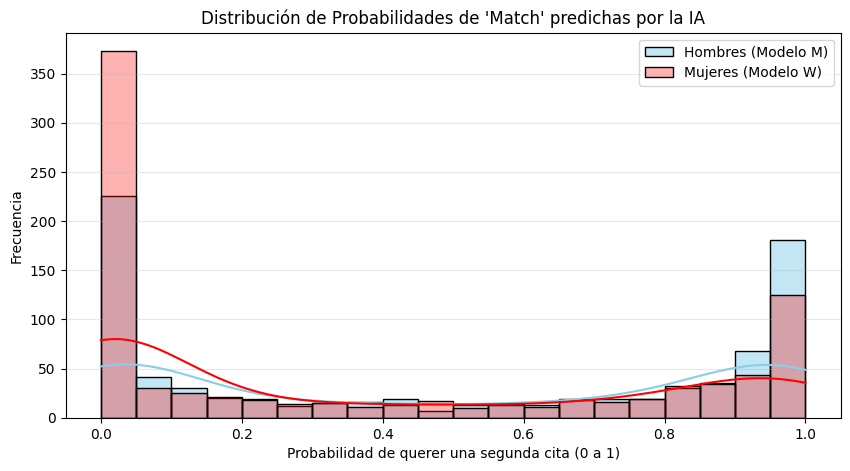

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(probs_hombres, color="skyblue", label="Hombres (Modelo M)", kde=True, bins=20)
sns.histplot(probs_mujeres, color="red", label="Mujeres (Modelo W)", kde=True, bins=20, alpha=0.3)

plt.title("Distribución de Probabilidades de 'Match' predichas por la IA")
plt.xlabel("Probabilidad de querer una segunda cita (0 a 1)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.savefig("distribucion_probabilidades.png", dpi=300)